# Hands on KiWi 2022-10-06

In [ ]:
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'  # always print last expr.
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import datetime
import warnings
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

warnings.filterwarnings(action="ignore", category=UserWarning, module="tsdm")

# Load 𝗧ime 𝗦eries 𝗗atasets & 𝗠odels (𝚝𝚜𝚍𝚖)

- Source: https://git.tu-berlin.de/bvt-htbd/kiwi/tf1/tsdm
- Documentation: https://bvt-htbd.gitlab-pages.tu-berlin.de/kiwi/tf1/tsdm/


### Installation

```bash
pip install tsdm --extra-index-url https://__token__:<your_personal_token>@git.tu-berlin.de/api/v4/projects/6694/packages/pypi/simple
```

**Note: This is all considered alpha software, API might change between versions!**

In [ ]:
import tsdm

## Time Series Datasets

### A **time series** is a tuple $D = (𝐓𝐒, M)$

- Time-indexed data $𝐓𝐒=\{(t_n v_n)∣n=1…N\}$
  - timestamps $t∈𝓣$, values $v∈𝓥$
- Time-independent metadata $M∈𝓜$


### A **time series collection** is a tuple $C = (I,S,G)$ consisting of

- Index $I⊆𝓘$ (of id's)
- Collection of timeseries $\{D_i=(𝐓𝐒_i, M_i) ∣ i∈𝓘，𝐓𝐒_i∈(𝓣×𝓥)_i^*， M_i∈𝓜_i\}$
- Index-independent Global data $G∈𝓖$
- If $𝓣_i=𝓣$, $𝓥_i=𝓥$ and $𝓜_i=𝓜$ ⟶ **equimodal**

## Examples

1. Clinical data:

    - index $𝓘$: patient / admission id
    - metadata $M_i$: patient metadata (age, sex, preconditions, ...)
    - values $V_i$: measured data (heart rate, blood pressure, etc.) 
    - globals $G$: units of measurement, measurement devices used, etc.
    
2. Bioreactor data

    - index $𝓘$: experiment / run id
    - metadata $M_i$: bacterial stem used, reactor size, reactor type
    - values $V_i$: measured data (O₂-, Glucose-, Acetate- concentration, stirring speed) 
    - globals $G$: units of measurement, measurement devices used, etc. 

# Load the dataset

In [ ]:
from tsdm.datasets import KIWI_RUNS

dataset = KIWI_RUNS()

In [ ]:
ts = dataset.timeseries

In [ ]:
md = dataset.metadata

In [ ]:
dataset.units

# Load the model & encoder

Preliminary API, ideally should be replaced with a database lookup.

- Model depends both on dataset and task, in particular the fold.
- Encoder depends both on model and dataset.
- ⇝ tags based lookup?: model, dataset, fold, epoch, hyperparameters

In [ ]:
from tsdm.models.pretrained import LinODEnet

model = LinODEnet()
summary(model)

## Make a prediction

In [ ]:
ts

In [ ]:
key = (run_id, experiment_id) = (510, 16871)
s = ts.loc[key].astype(float).copy()
s

In [ ]:
ts.reset_index(level=[0, 1], drop=True)

In [ ]:
from tsdm.encoders import *
from tsdm.tasks import KIWI_RUNS_TASK

train_ts, train_md = KIWI_RUNS_TASK().splits[(0, "train")]

encoder = Frame2Tensor() @ FrameEncoder(
    Standardizer() @ FloatEncoder(), index_encoders=MinMaxScaler() @ TimeDeltaEncoder()
)
# encoder.fit(train_ts.reset_index(level=[0,1], drop=True))
encoder.fit(train_ts.drop([355]).reset_index(level=[0, 1], drop=True))
# encoder.fit(ts.loc[510].reset_index(level=0, drop=True))
# encoder.fit(ts.loc[key])

In [ ]:
observables = ["Base", "DOT", "Glucose", "OD600", "Acetate", "Fluo_GFP", "Volume", "pH"]
controls = [
    "Cumulated_feed_volume_glucose",
    "Cumulated_feed_volume_medium",
    "InducerConcentration",
    "StirringSpeed",
    "Flow_Air",
    "Temperature",
    "Probe_Volume",
]

total_horizon = slice(np.timedelta64(3, "h"), np.timedelta64(9, "h"))
observation_horizon = slice(np.timedelta64(3, "h"), np.timedelta64(6, "h"))
forecasting_horizon = slice(np.timedelta64(6, "h"), np.timedelta64(9, "h"))

inputs = s.loc[total_horizon].copy()
inputs.loc[forecasting_horizon, observables] = float("nan")
inputs

In [ ]:
encoded = encoder.encode(inputs)
# decoded = encoder.decode(encoded)

In [ ]:
T, X = encoder.encode(inputs)

Xhat = model(T, X)

predictions = encoder.decode((T, Xhat))

In [ ]:
def get_predictions(key, t_start, t_mid, t_stop):
    # encoder = Frame2Tensor() @ FrameEncoder(
    #     Standardizer() @ FloatEncoder(), index_encoders=MinMaxScaler() @ TimeDeltaEncoder()
    # )
    # encoder.fit(ts.loc[key])

    observations = ts.loc[key].astype(float).copy()

    total_horizon = slice(t_start, t_stop)
    observation_horizon = slice(t_start, t_mid)
    forecasting_horizon = slice(t_mid, t_stop)

    inputs = observations.loc[total_horizon].copy()
    inputs.loc[forecasting_horizon, observables] = float("nan")
    T, X = encoder.encode(inputs)
    Xhat = model(T, X)
    predictions = encoder.decode((T, Xhat))

    return observations, predictions, Xhat

# Make a Prediction with the model

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

target = "DOT"  # "DOT" "Base", "DOT", "Glucose", "OD600", "Acetate", "Fluo_GFP", "pH"

key = run_id, exp_id = (
    474,
    16120,
)  # (474, 16120) (510, 16871)  (445, 15527)  (474, 16120) (484, 16346) (449, 15653)
h = np.timedelta64(1, "h")
t_start = np.timedelta64(1, "h")
t_mid = np.timedelta64(8, "h")
t_stop = t_mid + np.timedelta64(2, "h")

observations, predictions, xhat = get_predictions(
    (run_id, exp_id), t_start, t_mid, t_stop
)

Xhat_observation = predictions[t_start:t_mid]
Xhat_forecasting = predictions[t_mid:t_stop]
# T = observations.index.to_numpy() / np.timedelta64(1, "h")
# T_observation = Xhat_observation.index / np.timedelta64(1, "h")
# T_forecasting = Xhat_forecasting.index / np.timedelta64(1, "h")

ax.plot(observations.index / h, observations[target], ".b", label=f"{target} observed")
ax.plot(
    Xhat_observation.index / h,
    Xhat_observation[target],
    ":r",
    label=f"{target} estimated",
)
ax.plot(
    Xhat_forecasting.index / h,
    Xhat_forecasting[target],
    "-r",
    label=f"{target} estimated",
)
ax.axvspan(t_start, t_mid, facecolor="grey", alpha=0.3)
ax.axvspan(t_mid, t_stop, facecolor="green", alpha=0.3)
# ax.set_ylim(observations[target].min(), observations[target].max())
ax.legend()

## Glitches in the data

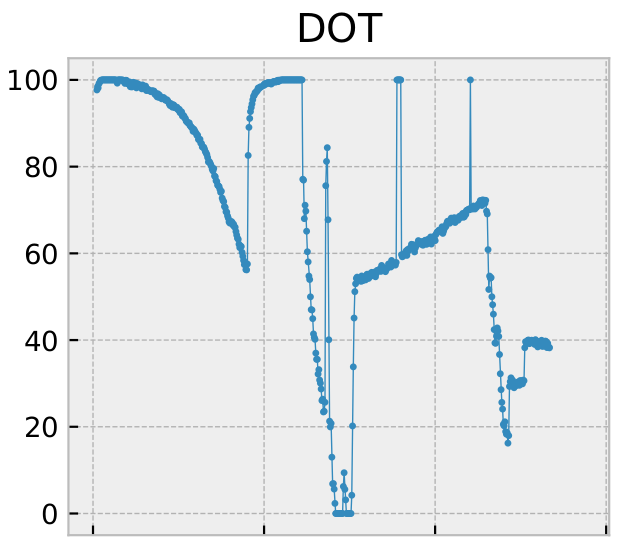
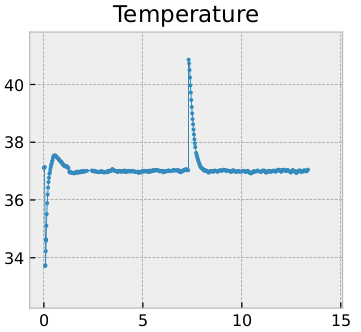
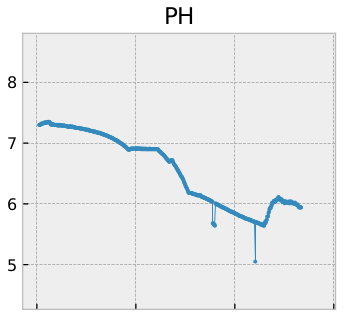
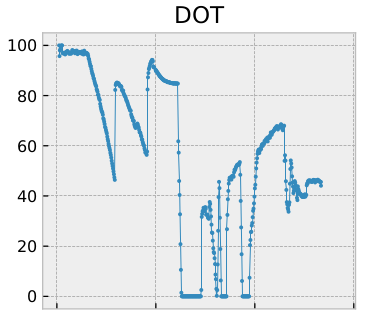

## How it should look like

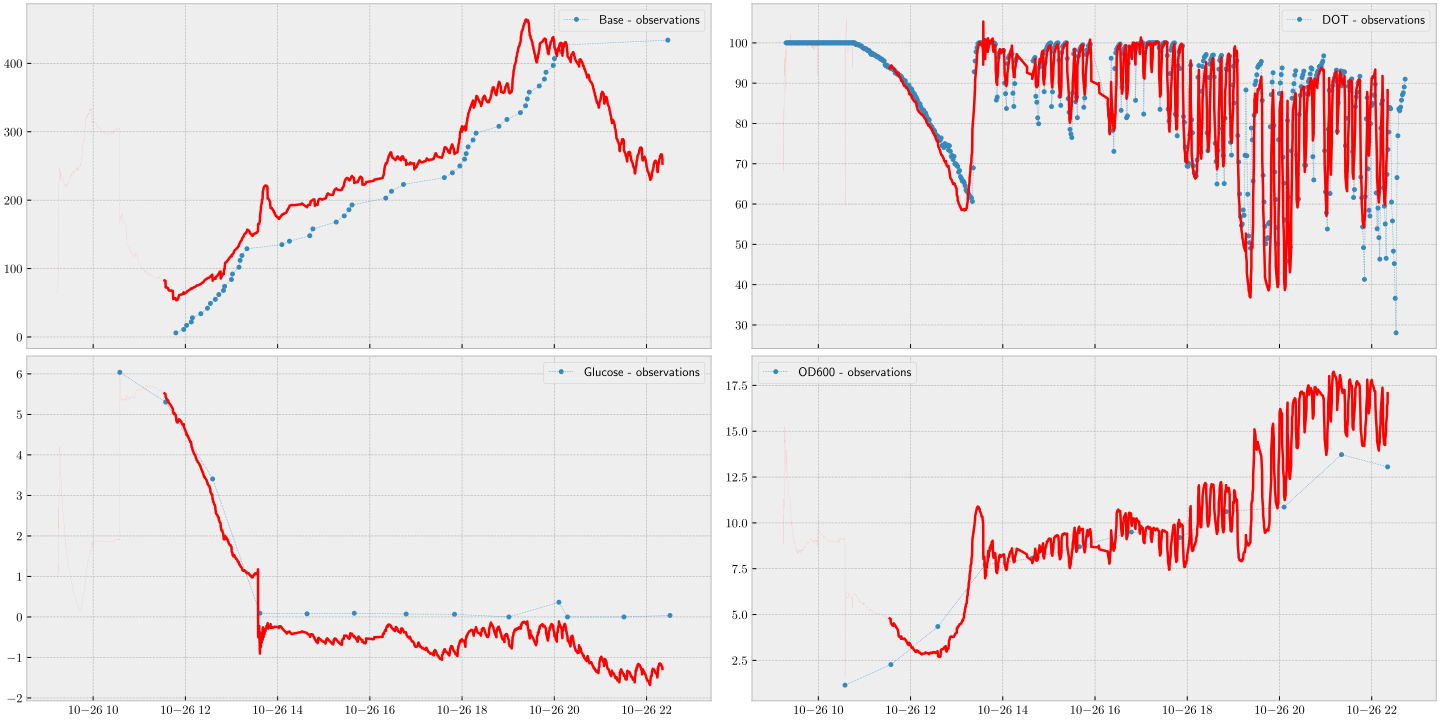